In [1]:
import numpy as np
import tflearn
import tflearn.activations as activations
# Data loading and preprocessing
from tflearn.activations import relu
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.conv import avg_pool_2d, conv_2d, max_pool_2d
from tflearn.layers.core import dropout, flatten, fully_connected, input_data
from tflearn.layers.merge_ops import merge
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.normalization import batch_normalization


#chris library imports
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

from test_recursive_image_load_V2 import load_CKP_data
from test_recursive_image_load_V2 import load_formated_data
from test_recursive_image_load_V2 import split_dataset
from test_recursive_image_load_V2 import divide_subjects
from test_recursive_image_load_V2 import divide_data_to_subject

from showNumpyInfo import showInfo

from Dexpression_network import create_Dexpression_old_network

from confusion_matrix import plot_conf_mat
from confusion_matrix import extract_classes

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
# global Paths to define for each specific computer
#tf_checkpoints = where the checkpoints of tensorflow training algorithms are stored to be recovered if necessary
tf_checkpoints = "G:/Documenten/personal/school/MaNaMA_AI/thesis/implementation/dexpression/github_1/github/Thesis_Christiaan_Jean/Custom_Dexpression/tf_checkpoints"

#load data
try:
    X_data = np.load('../data/CKP_X.npy')
    Y_data = np.load('../data/CKP_Y.npy')
    X_subID = (np.load('../data/CKP_subjectIds.npy')).astype('uint8')
except:
    X_data = np.load('G:/Documenten/personal/school/MaNaMA_AI/thesis/implementation/dexpression/github_1/github/Thesis_Christiaan_Jean/data/CKP_X.npy')
    Y_data = np.load('G:/Documenten/personal/school/MaNaMA_AI/thesis/implementation/dexpression/github_1/github/Thesis_Christiaan_Jean/data/CKP_Y.npy')
    X_subID = (np.load('G:/Documenten/personal/school/MaNaMA_AI/thesis/implementation/dexpression/github_1/github/Thesis_Christiaan_Jean/data/CKP_subjectIds.npy')).astype('uint8')

#load the subject distribution over the different datasets
subID = (np.load('data_division/train_subject_ID.npy')).astype('uint8')
subID_val = (np.load('data_division/validation_subject_ID.npy')).astype('uint8')
subID_test = (np.load('data_division/test_subject_ID.npy')).astype('uint8')
subIDs = [subID, subID_val, subID_test]

divided_data = divide_data_to_subject([X_data,Y_data,X_subID],subIDs)

X = (divided_data[0].reshape(-1,224,224,1)).astype('uint8')
Y = (divided_data[1].reshape(-1,7)).astype('uint8')

# create the validation set X_val and Y-val (SubID_val is not given to the network)
X_val = divided_data[2].reshape(-1,224,224,1).astype('uint8')
Y_val = divided_data[3].reshape(-1,7).astype('uint8')

# create the test set X_test and Y_test (SubID_test is not given to the network)
X_test = divided_data[4].reshape(-1,224,224,1).astype('uint8')
Y_test = divided_data[5].reshape(-1,7).astype('uint8')    

In [3]:
network = create_Dexpression_old_network()

#create a custom tensorflow session to manage the used resources
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config = config)


# Final definition of model checkpoints and other configurations
#model = tflearn.DNN(network, checkpoint_path='/home/cc/DeXpression/DeXpression_checkpoints',
model = tflearn.DNN(network, checkpoint_path=tf_checkpoints,
                    max_checkpoints=1, tensorboard_verbose=2, tensorboard_dir="./tflearn_logs/")


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [4]:
model.load('./tf_checkpoints/DeXpression_run_3.model')

INFO:tensorflow:Restoring parameters from G:\Documenten\personal\school\MaNaMA_AI\thesis\implementation\dexpression\condor_runs\3_29-03-2018\tf_checkpoints\DeXpression_run_3.model


In [5]:
# predictions 
Y_val_pred = model.predict(X_val)  # predictions
Y_test_pred = model.predict(X_test)  # predictions

Y_train_pred_class = extract_classes(model.predict(X[:50]))
Y_train_pred_class = np.append(Y_train_pred_class,extract_classes(model.predict(X[50:100])))
Y_train_pred_class = np.append(Y_train_pred_class,extract_classes(model.predict(X[100:150])))
Y_train_pred_class = np.append(Y_train_pred_class,extract_classes(model.predict(X[150:200])))
Y_train_pred_class = np.append(Y_train_pred_class,extract_classes(model.predict(X[200:250])))
Y_train_pred_class = np.append(Y_train_pred_class,extract_classes(model.predict(X[250:])))
Y_train_class = extract_classes(Y)

# extracting classes
Y_val_pred_class = extract_classes(Y_val_pred)
Y_val_class = extract_classes(Y_val)

Y_test_pred_class = extract_classes(Y_test_pred)
Y_test_class = extract_classes(Y_test)


# making full dataset
Y_pred_class = Y_train_pred_class
Y_pred_class = np.append(Y_pred_class,Y_val_pred_class)
Y_pred_class = np.append(Y_pred_class,Y_test_pred_class) 

Y_class = np.append(Y_train_class,Y_val_class)
Y_class = np.append(Y_class,Y_test_class)

In [6]:
# extracting classes
Y_val_pred_class = extract_classes(Y_val_pred)
Y_val_class = extract_classes(Y_val)

Y_test_pred_class = extract_classes(Y_test_pred)
Y_test_class = extract_classes(Y_test)


# making full dataset
Y_pred_class = Y_train_pred_class
Y_pred_class = np.append(Y_pred_class,Y_val_pred_class)
Y_pred_class = np.append(Y_pred_class,Y_test_pred_class) 

Y_class = np.append(Y_train_class,Y_val_class)
Y_class = np.append(Y_class,Y_test_class)

In [7]:
conf_mat_train = tf.confusion_matrix(Y_train_class,Y_train_pred_class,num_classes=7,dtype=tf.int32)#,# name=None,# weights=None)
conf_mat_val = tf.confusion_matrix(Y_val_class,Y_val_pred_class,num_classes=7,dtype=tf.int32)#,# name=None,# weights=None)
conf_mat_test = tf.confusion_matrix(Y_test_class,Y_test_pred_class,num_classes=7,dtype=tf.int32)#,# name=None,# weights=None)
conf_mat = tf.confusion_matrix(Y_class,Y_pred_class,num_classes=7,dtype=tf.int32)#,# name=None,# weights=None)


In [9]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())


In [33]:
#conf_mat_norm = np.round(normalize(sess.run(conf_mat),axis=1),decimals=6)*100
# normalization is incorrect!!!!
conf_mat_norm = normalize(sess.run(conf_mat),axis=0)

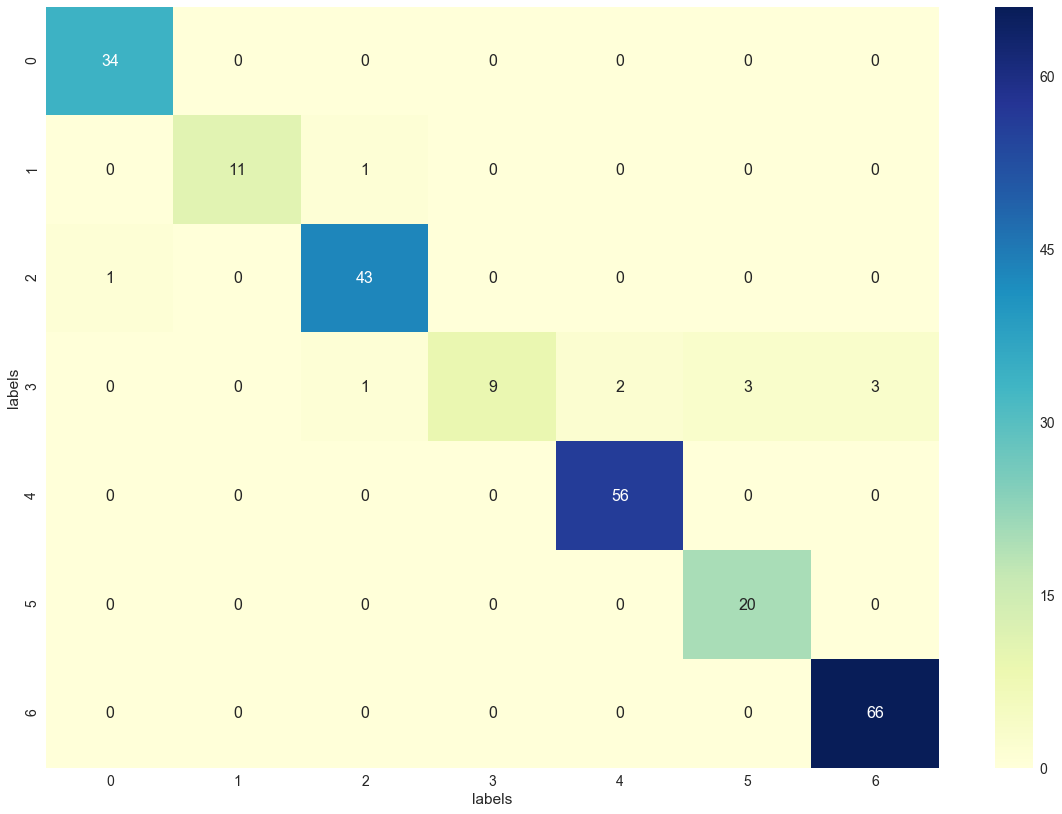

In [23]:
plot_conf_mat(sess.run(conf_mat_train))

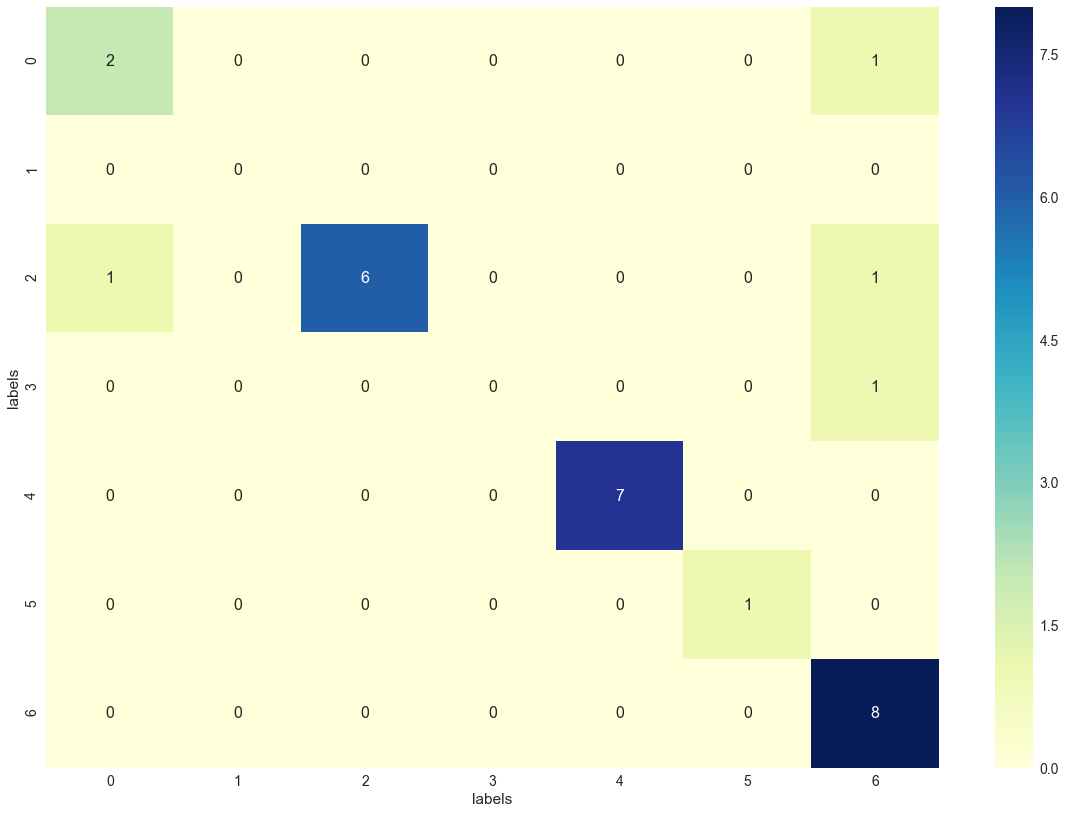

In [24]:
plot_conf_mat(sess.run(conf_mat_val))

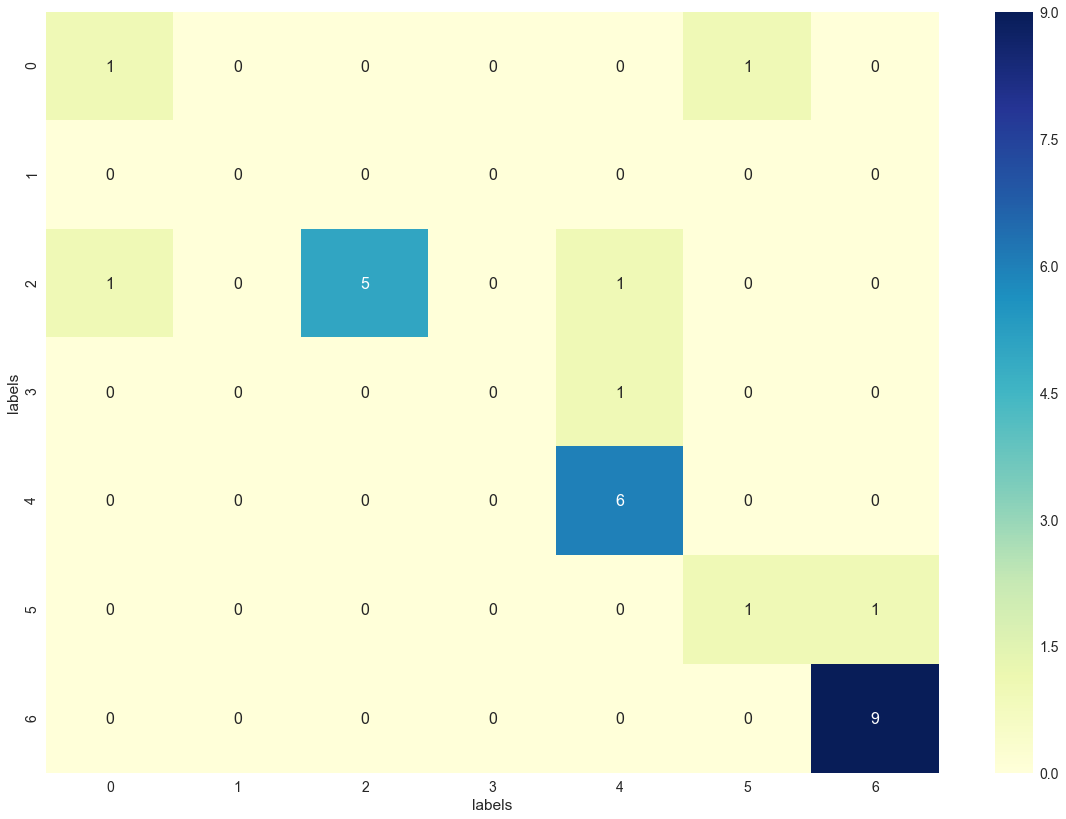

In [25]:
plot_conf_mat(sess.run(conf_mat_test))

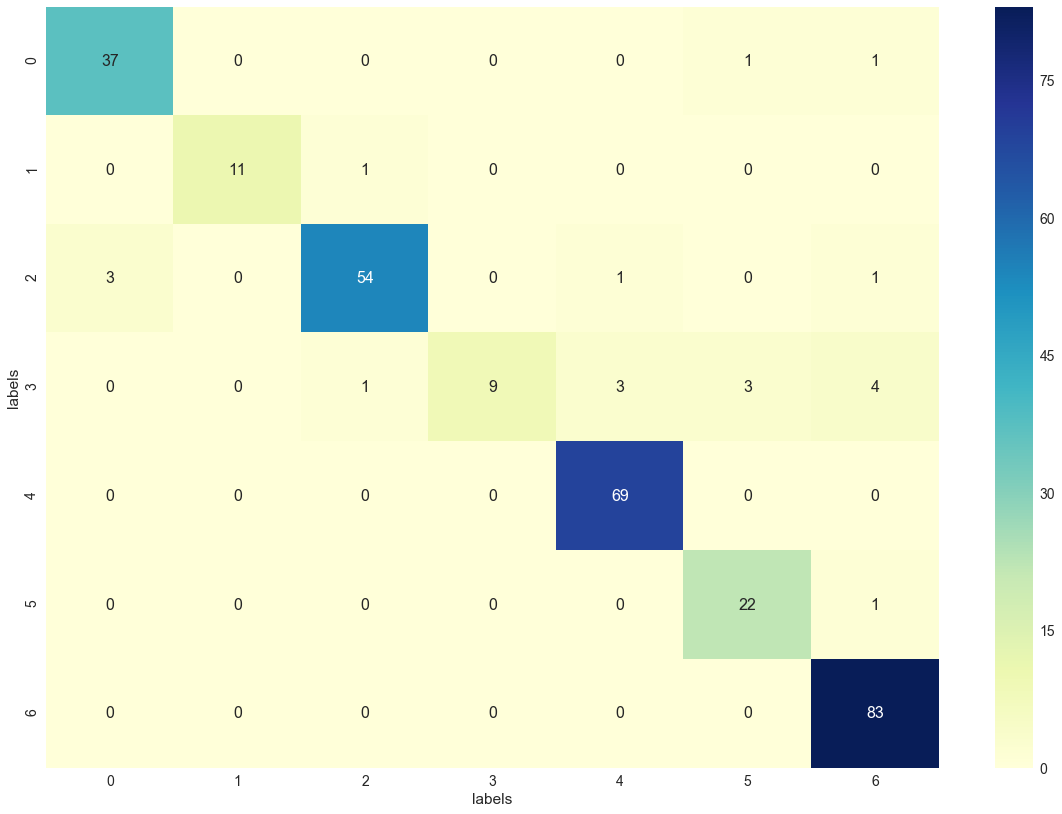

In [26]:
plot_conf_mat(sess.run(conf_mat))

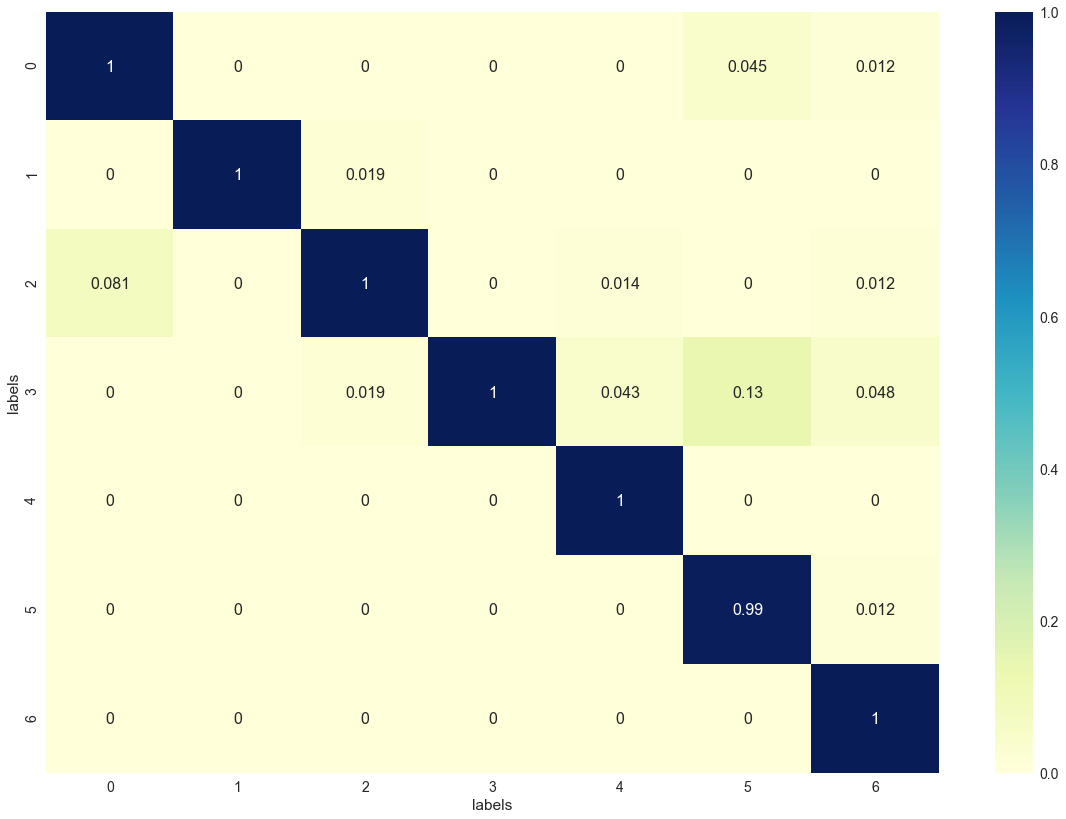

In [34]:
# normalization is incorrect!!!!
plot_conf_mat(conf_mat_norm)

In [36]:
np.set_printoptions(threshold=np.nan)
np.set_printoptions(suppress=True)

# normalization is incorrect!!!!
print(np.round(conf_mat_norm,decimals = 5))

[[0.99673 0.      0.      0.      0.      0.04499 0.01203]
 [0.      1.      0.01851 0.      0.      0.      0.     ]
 [0.08082 0.      0.99966 0.      0.01448 0.      0.01203]
 [0.      0.      0.01851 1.      0.04343 0.13498 0.04813]
 [0.      0.      0.      0.      0.99895 0.      0.     ]
 [0.      0.      0.      0.      0.      0.98983 0.01203]
 [0.      0.      0.      0.      0.      0.      0.99862]]
